## Notebook - Table of Contents


1. [**Basic Data Analysis**](#1.-Basic-Data-Analysis)  
    1.1 [**Importing the necessary libraries & loading the data**](#1.1-Importing-the-necessary-libraries-&-loading-the-data)    
    1.2 [**Basic statistics - Number of products, subcategories & gender**](#1.2-Basic-statistics---Number-of-products,-subcategories-&-gender)      
    1.3 [**Frequency of each gender**](#1.3-Frequency-of-each-gender)      
    1.4 [**Distribution of products gender-wise**](#1.4-Distribution-of-products-gender-wise)     
2. [**Data Preparation**](#2.-Data-Preparation) 
3. [**Feature extraction using ResNet**](#3.-Feature-extraction-using-ResNet)  
4. [**Computing the Euclidean distance and recommending similar products**](#4.-Computing-the-Euclidean-distance-and-recommending-similar-products)                         
    4.1 [**Loading the extracted features**](#4.1-Loading-the-extracted-features)  
    4.2 [**Distance computation and Recommendation**](#4.2-Distance-computation-and-Recommendation)  
5. [**Deploying the solution**](#5.-Deploying-the-solution)  

### Basic Data Analysis

#### 1.1 Importing the necessary libraries & loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
#import streamlit as st
#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image


fashion_df = pd.read_csv("C:\\Users\\HUSTAR25\\Desktop\\AI\\mobile_project\\data\\fashion.csv")
fashion_df

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2901,51755,Women,Footwear,Shoes,Casual Shoes,Black,Casual,Catwalk Women Black Shoes,51755.jpg,http://assets.myntassets.com/v1/images/style/p...
2902,47630,Women,Footwear,Shoes,Flats,Blue,Casual,Carlton London Women Blue Shoes,47630.jpg,http://assets.myntassets.com/v1/images/style/p...
2903,32836,Women,Footwear,Shoes,Flats,Pink,Casual,Grendha Women Flori Pink Sandals,32836.jpg,http://assets.myntassets.com/v1/images/style/p...
2904,35821,Women,Footwear,Shoes,Heels,Black,Casual,Enroute Women Black Heels,35821.jpg,http://assets.myntassets.com/v1/images/style/p...


In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

#### 1.2 Basic statistics - Number of products, subcategories & gender

In [3]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["SubCategory"].nunique())
print("Total number of unique gender types : ", fashion_df["Gender"].nunique())

Total number of products :  2906
Total number of unique subcategories :  9
Total number of unique gender types :  4


#### 1.3 Frequency of each gender

In [4]:
fashion_df["Gender"].value_counts()

Men      811
Women    769
Boys     759
Girls    567
Name: Gender, dtype: int64

#### 1.4 Distribution of products gender-wise

C:\Users\HUSTAR25\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


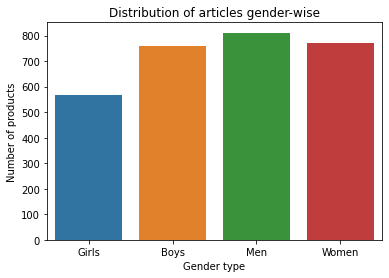

In [5]:
plot = sns.countplot(fashion_df["Gender"])
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())
plt.show()

### 2. Data Preparation

In [6]:
apparel_boys = fashion_df[fashion_df["Gender"]=="Boys"]
apparel_girls = fashion_df[fashion_df["Gender"]=="Girls"]
footwear_men = fashion_df[fashion_df["Gender"]=="Men"]
footwear_women = fashion_df[fashion_df["Gender"]=="Women"]

### 3. Feature extraction using ResNet

**For Gender - Men**

In [8]:
img_width, img_height = 224, 224

#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "C:\\Users\\HUSTAR25\\Desktop\\AI\\mobile_project\\data\\Footwear"

nb_train_samples = 811
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        #print(i)
        #print(i[(i.find("\\", 26, 50)+1):i.find(".")])
        Itemcodes.append(i[(i.find("\\", 26, 50)+1):i.find(".")])
        #print(Itemcodes)
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((811, 100352))


    
    np.save(open('./Men_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Men_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 1580 images belonging to 2 classes.


C:\Users\HUSTAR25\AppData\Local\Temp\ipykernel_25672\617290095.py:25: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:01:16.239157


### 4. Computing the Euclidean distance and recommending similar products

#### 4.1 Loading the extracted features

In [14]:
extracted_features = np.load('C:\\Users\\HUSTAR25\\Desktop\\AI\\mobile_project\\Men_ResNet_features.npy')
Productids = np.load('C:\\Users\\HUSTAR25\\Desktop\\AI\\mobile_project\\Men_ResNet_feature_product_ids.npy')
men = footwear_men.copy()
#men = pd.read_csv('./footwear_men.csv')
df_Productids = list(men['ProductId'])
Productids = list(Productids)

print(extracted_features)

[[0.        0.        0.        ... 4.599536  0.        0.       ]
 [0.        0.        0.        ... 4.5538154 0.        0.       ]
 [0.        0.        0.        ... 4.5364566 0.        0.       ]
 ...
 [0.        0.        0.        ... 4.5658436 0.        0.       ]
 [0.        0.        0.        ... 4.5091176 0.        0.       ]
 [0.        0.        0.        ... 4.3515377 0.        0.       ]]


#### 4.2 Distance computation and Recommendation

==================== input product image ====================


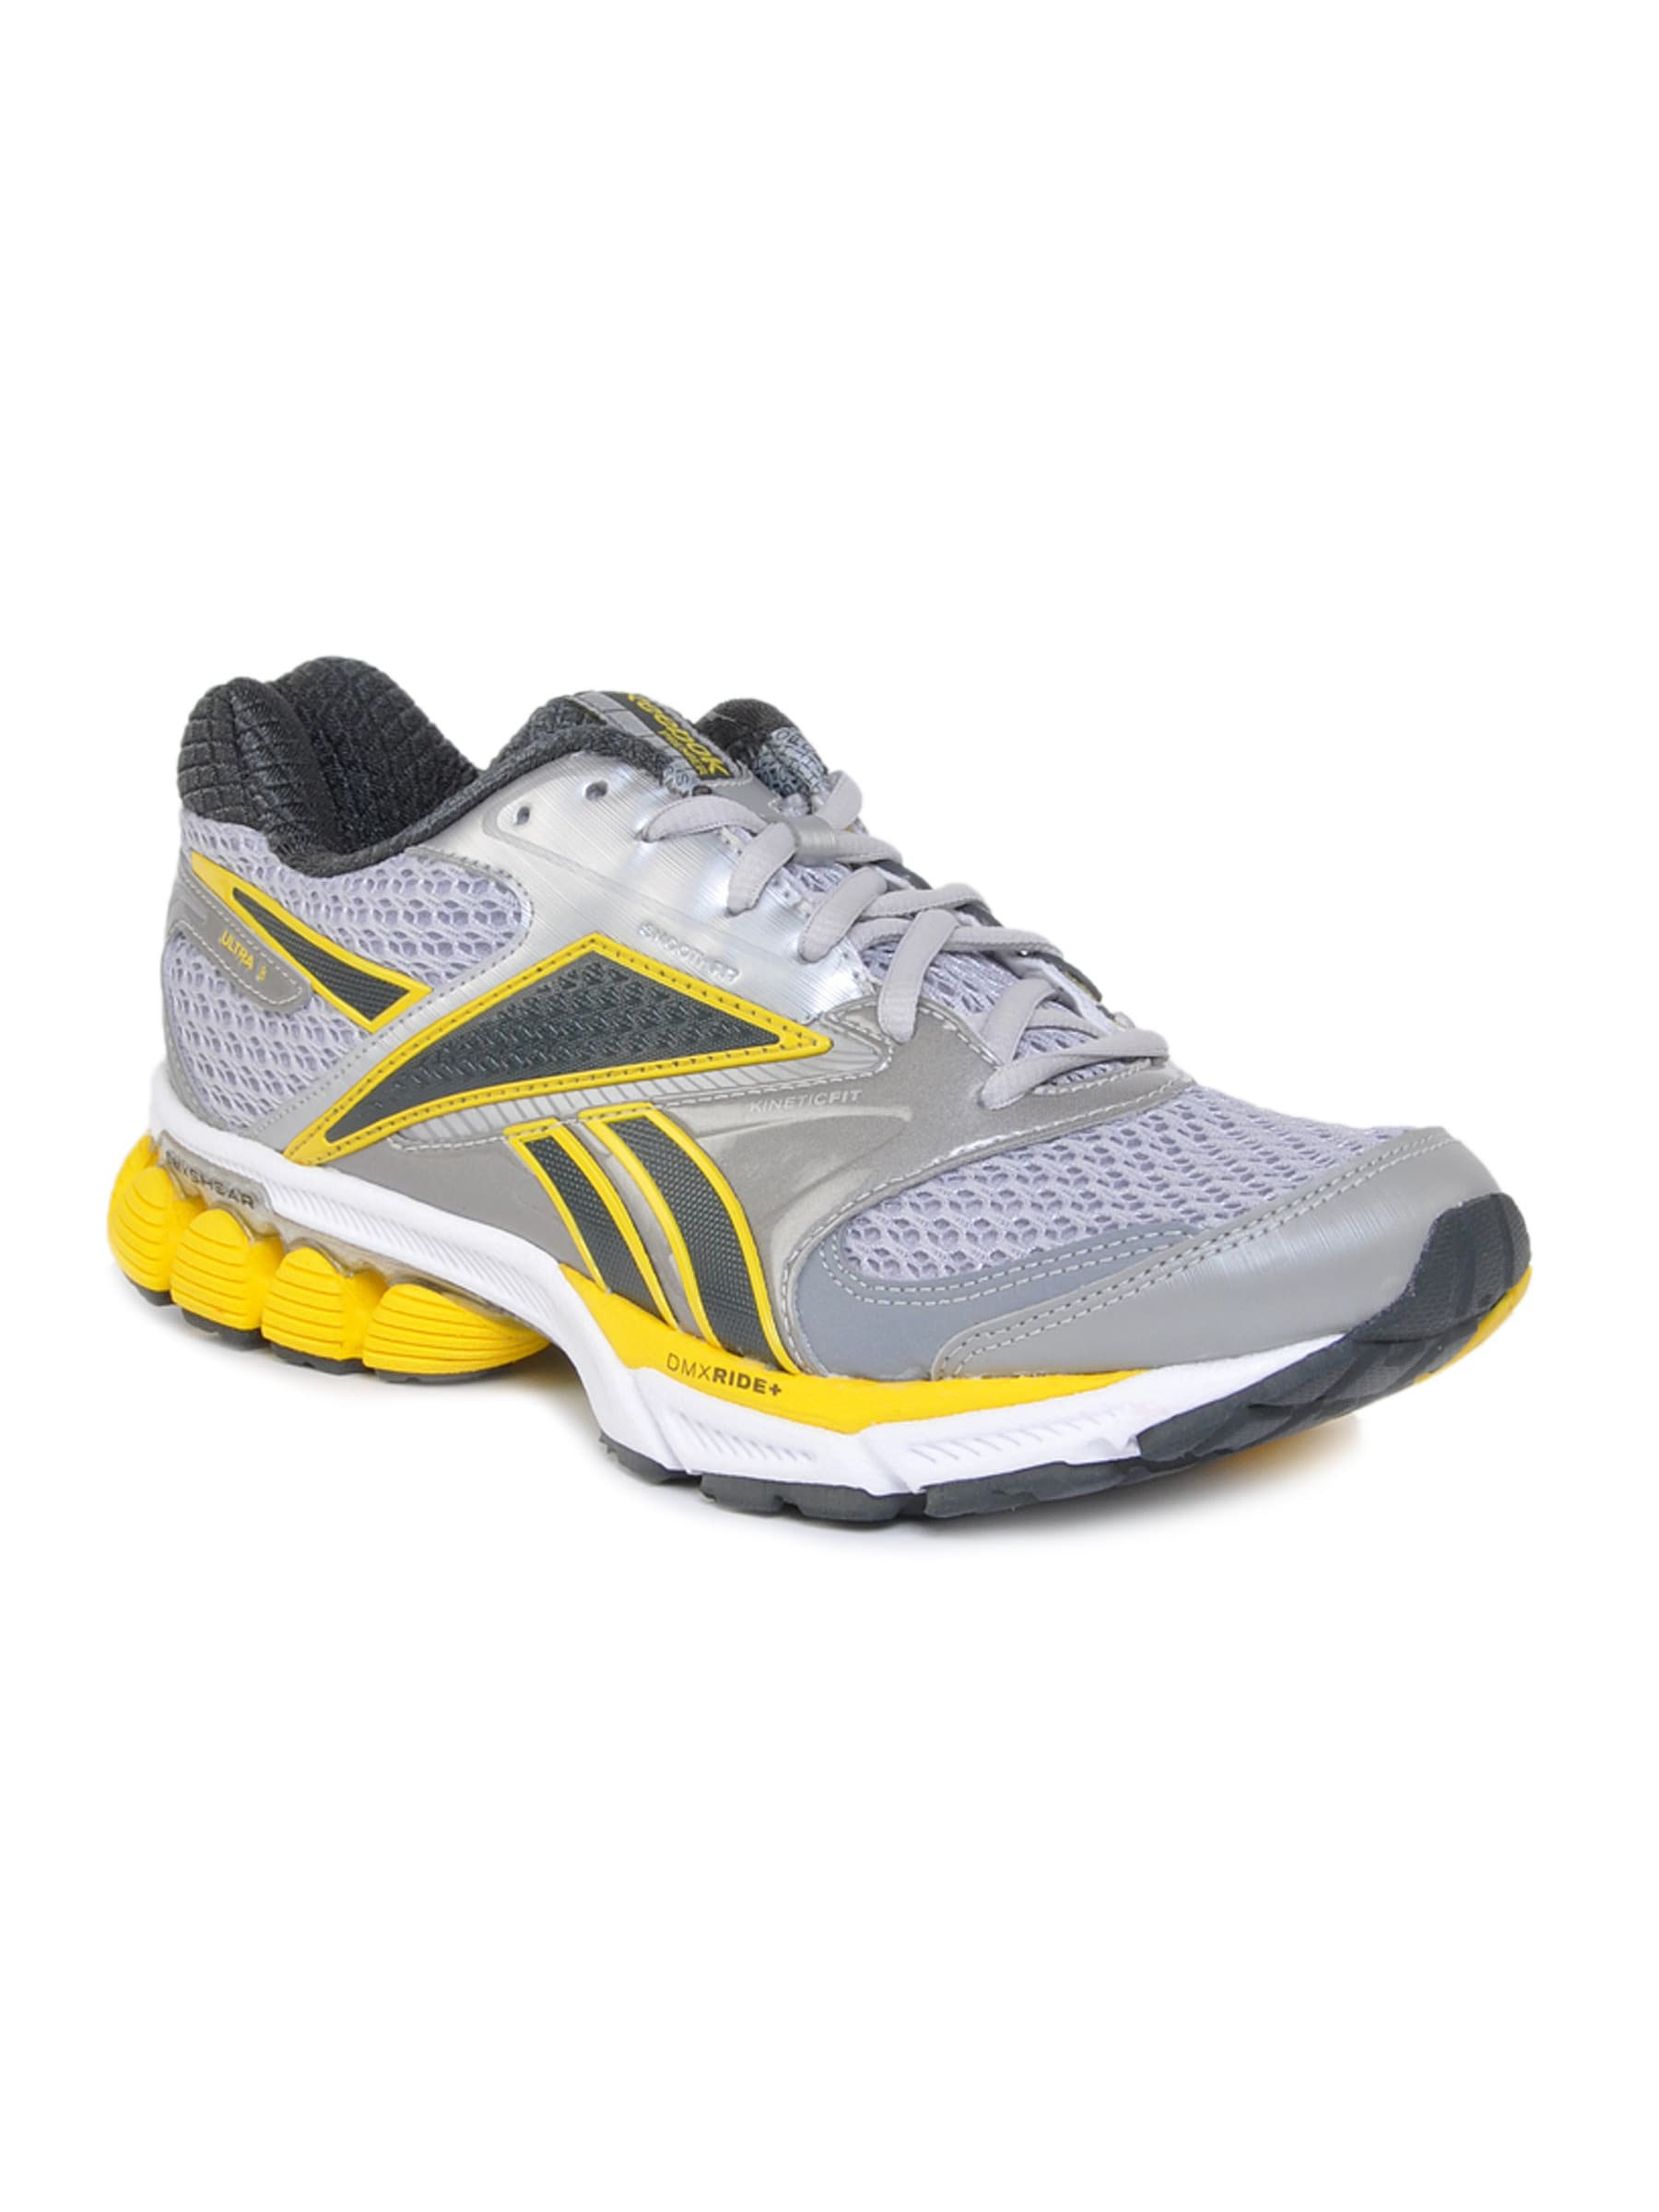

Product Title:  Reebok Men Premier ultra 8 U-form Silver Sports Shoes

 ==================== Recommended products ====================


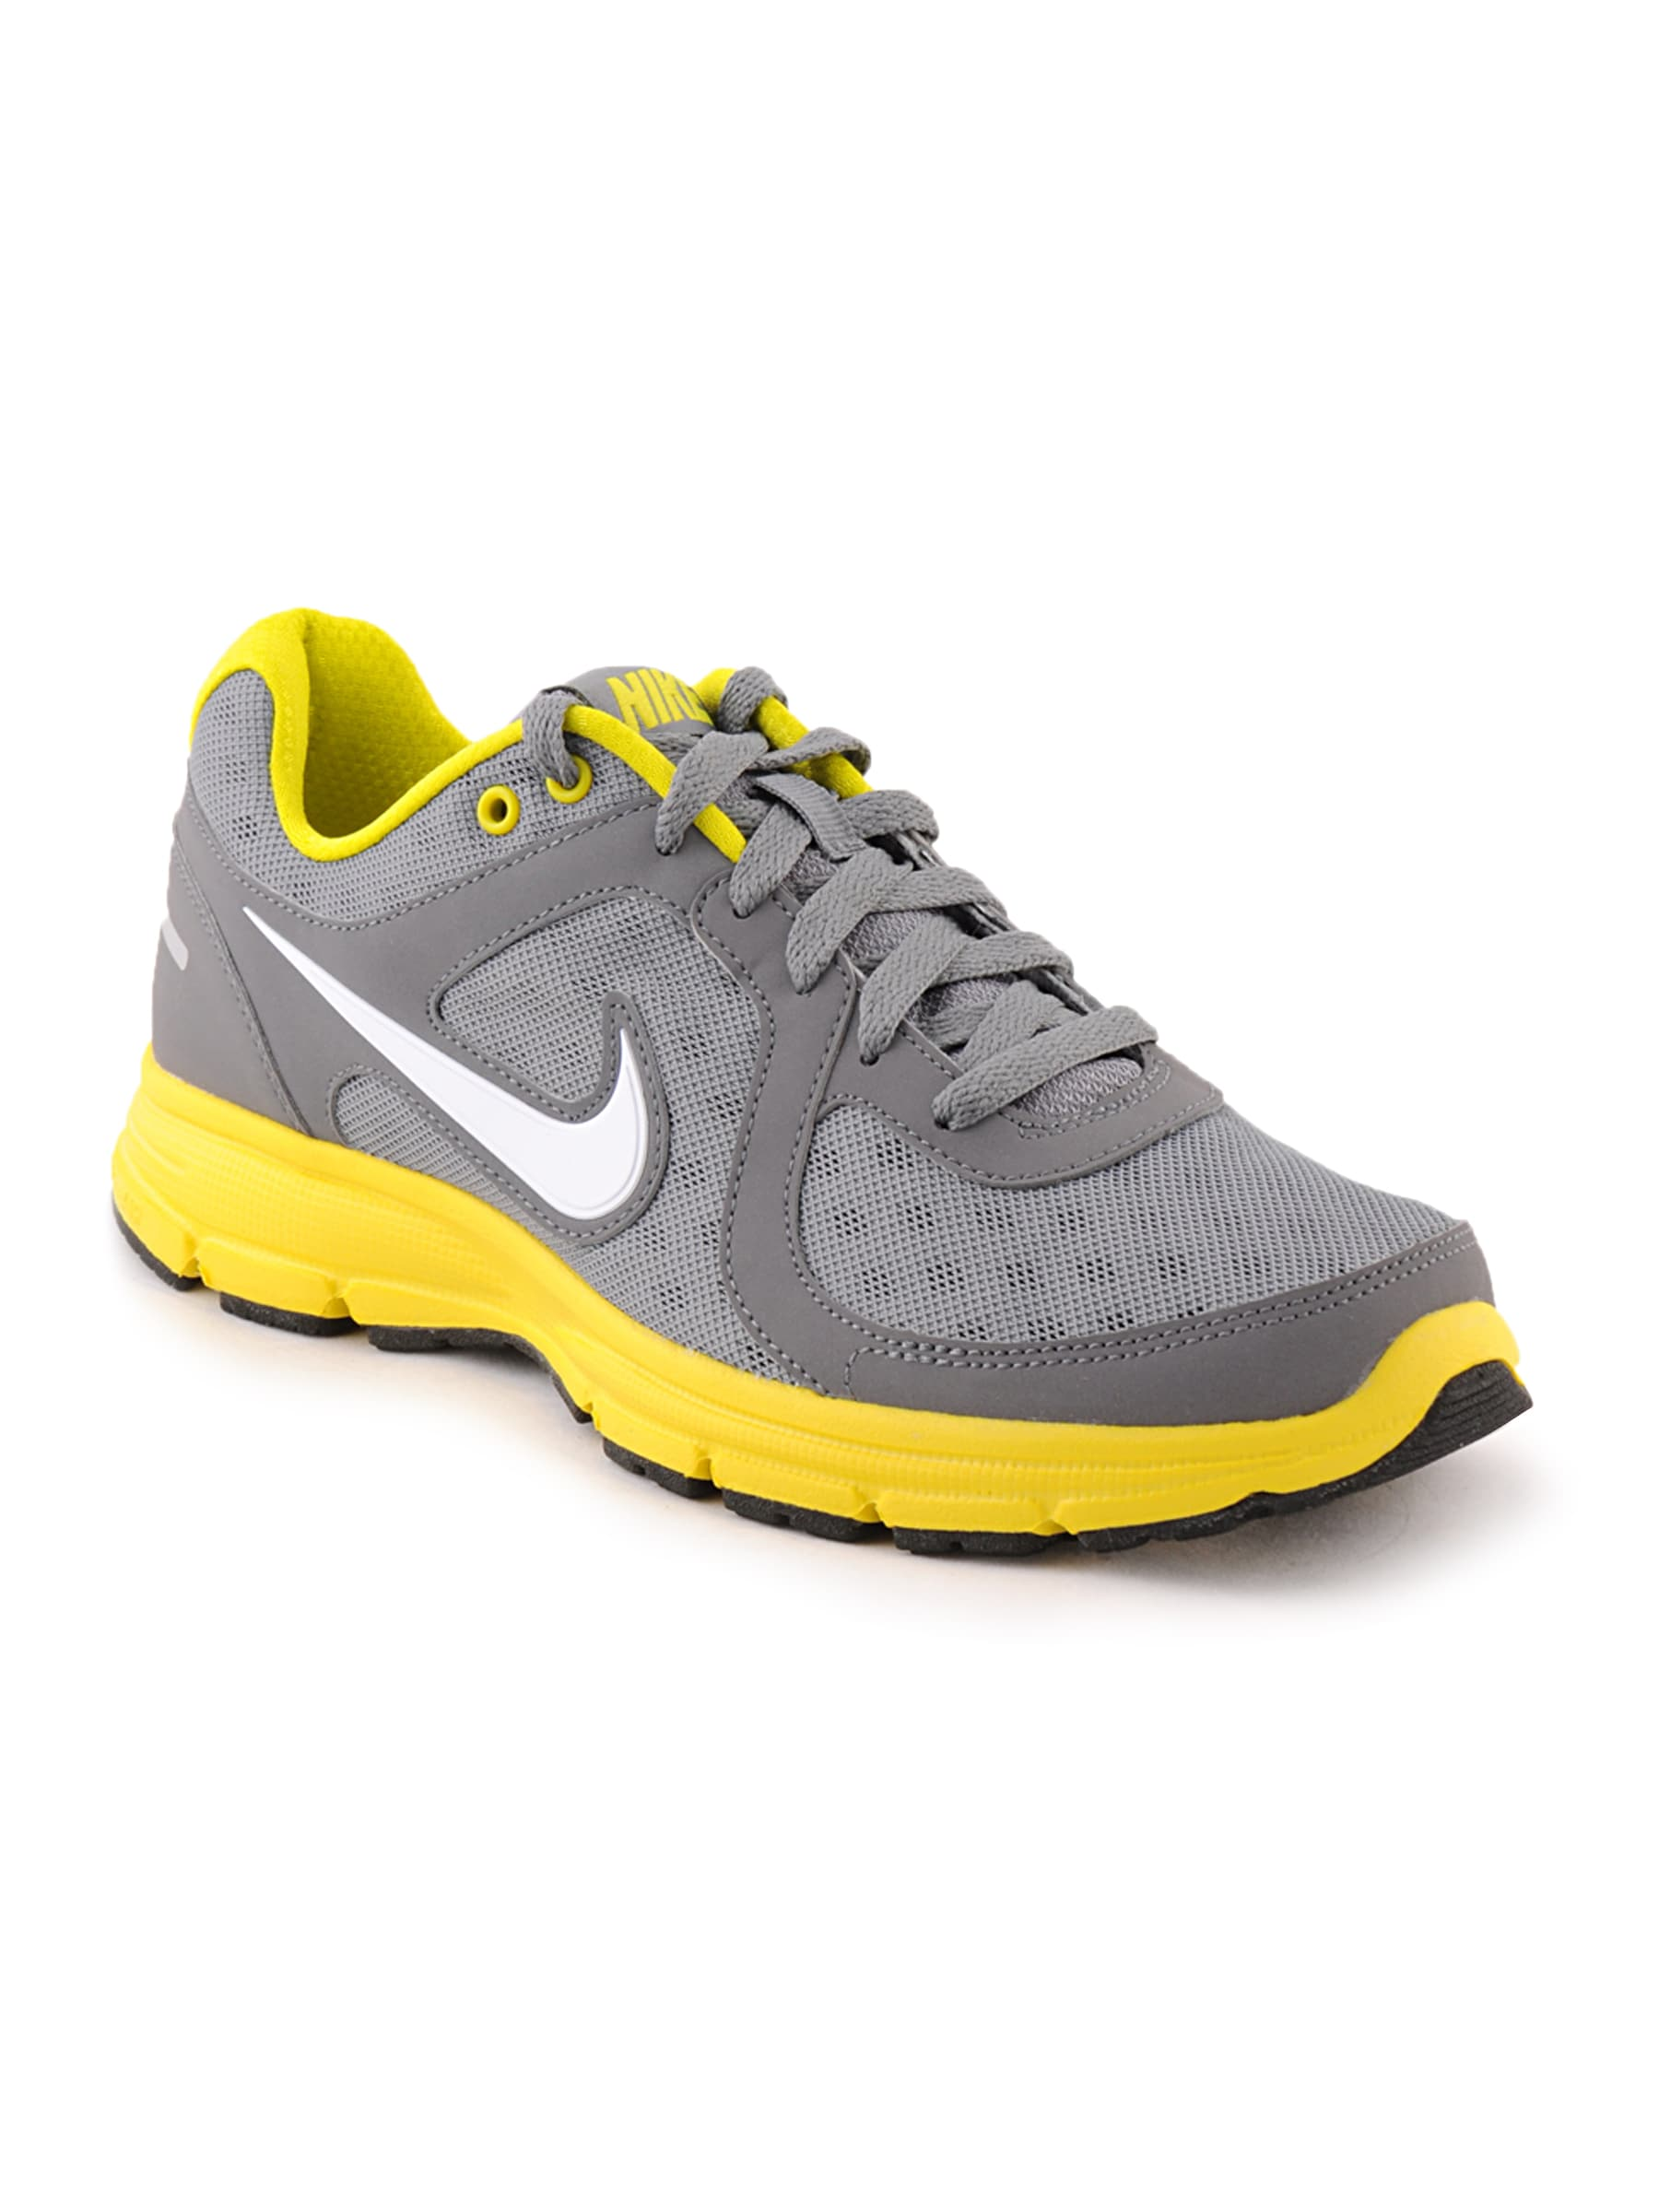

Product Title:  Nike Men Air Relentness Grey Sports Shoes
Euclidean Distance from input image: 20.691692


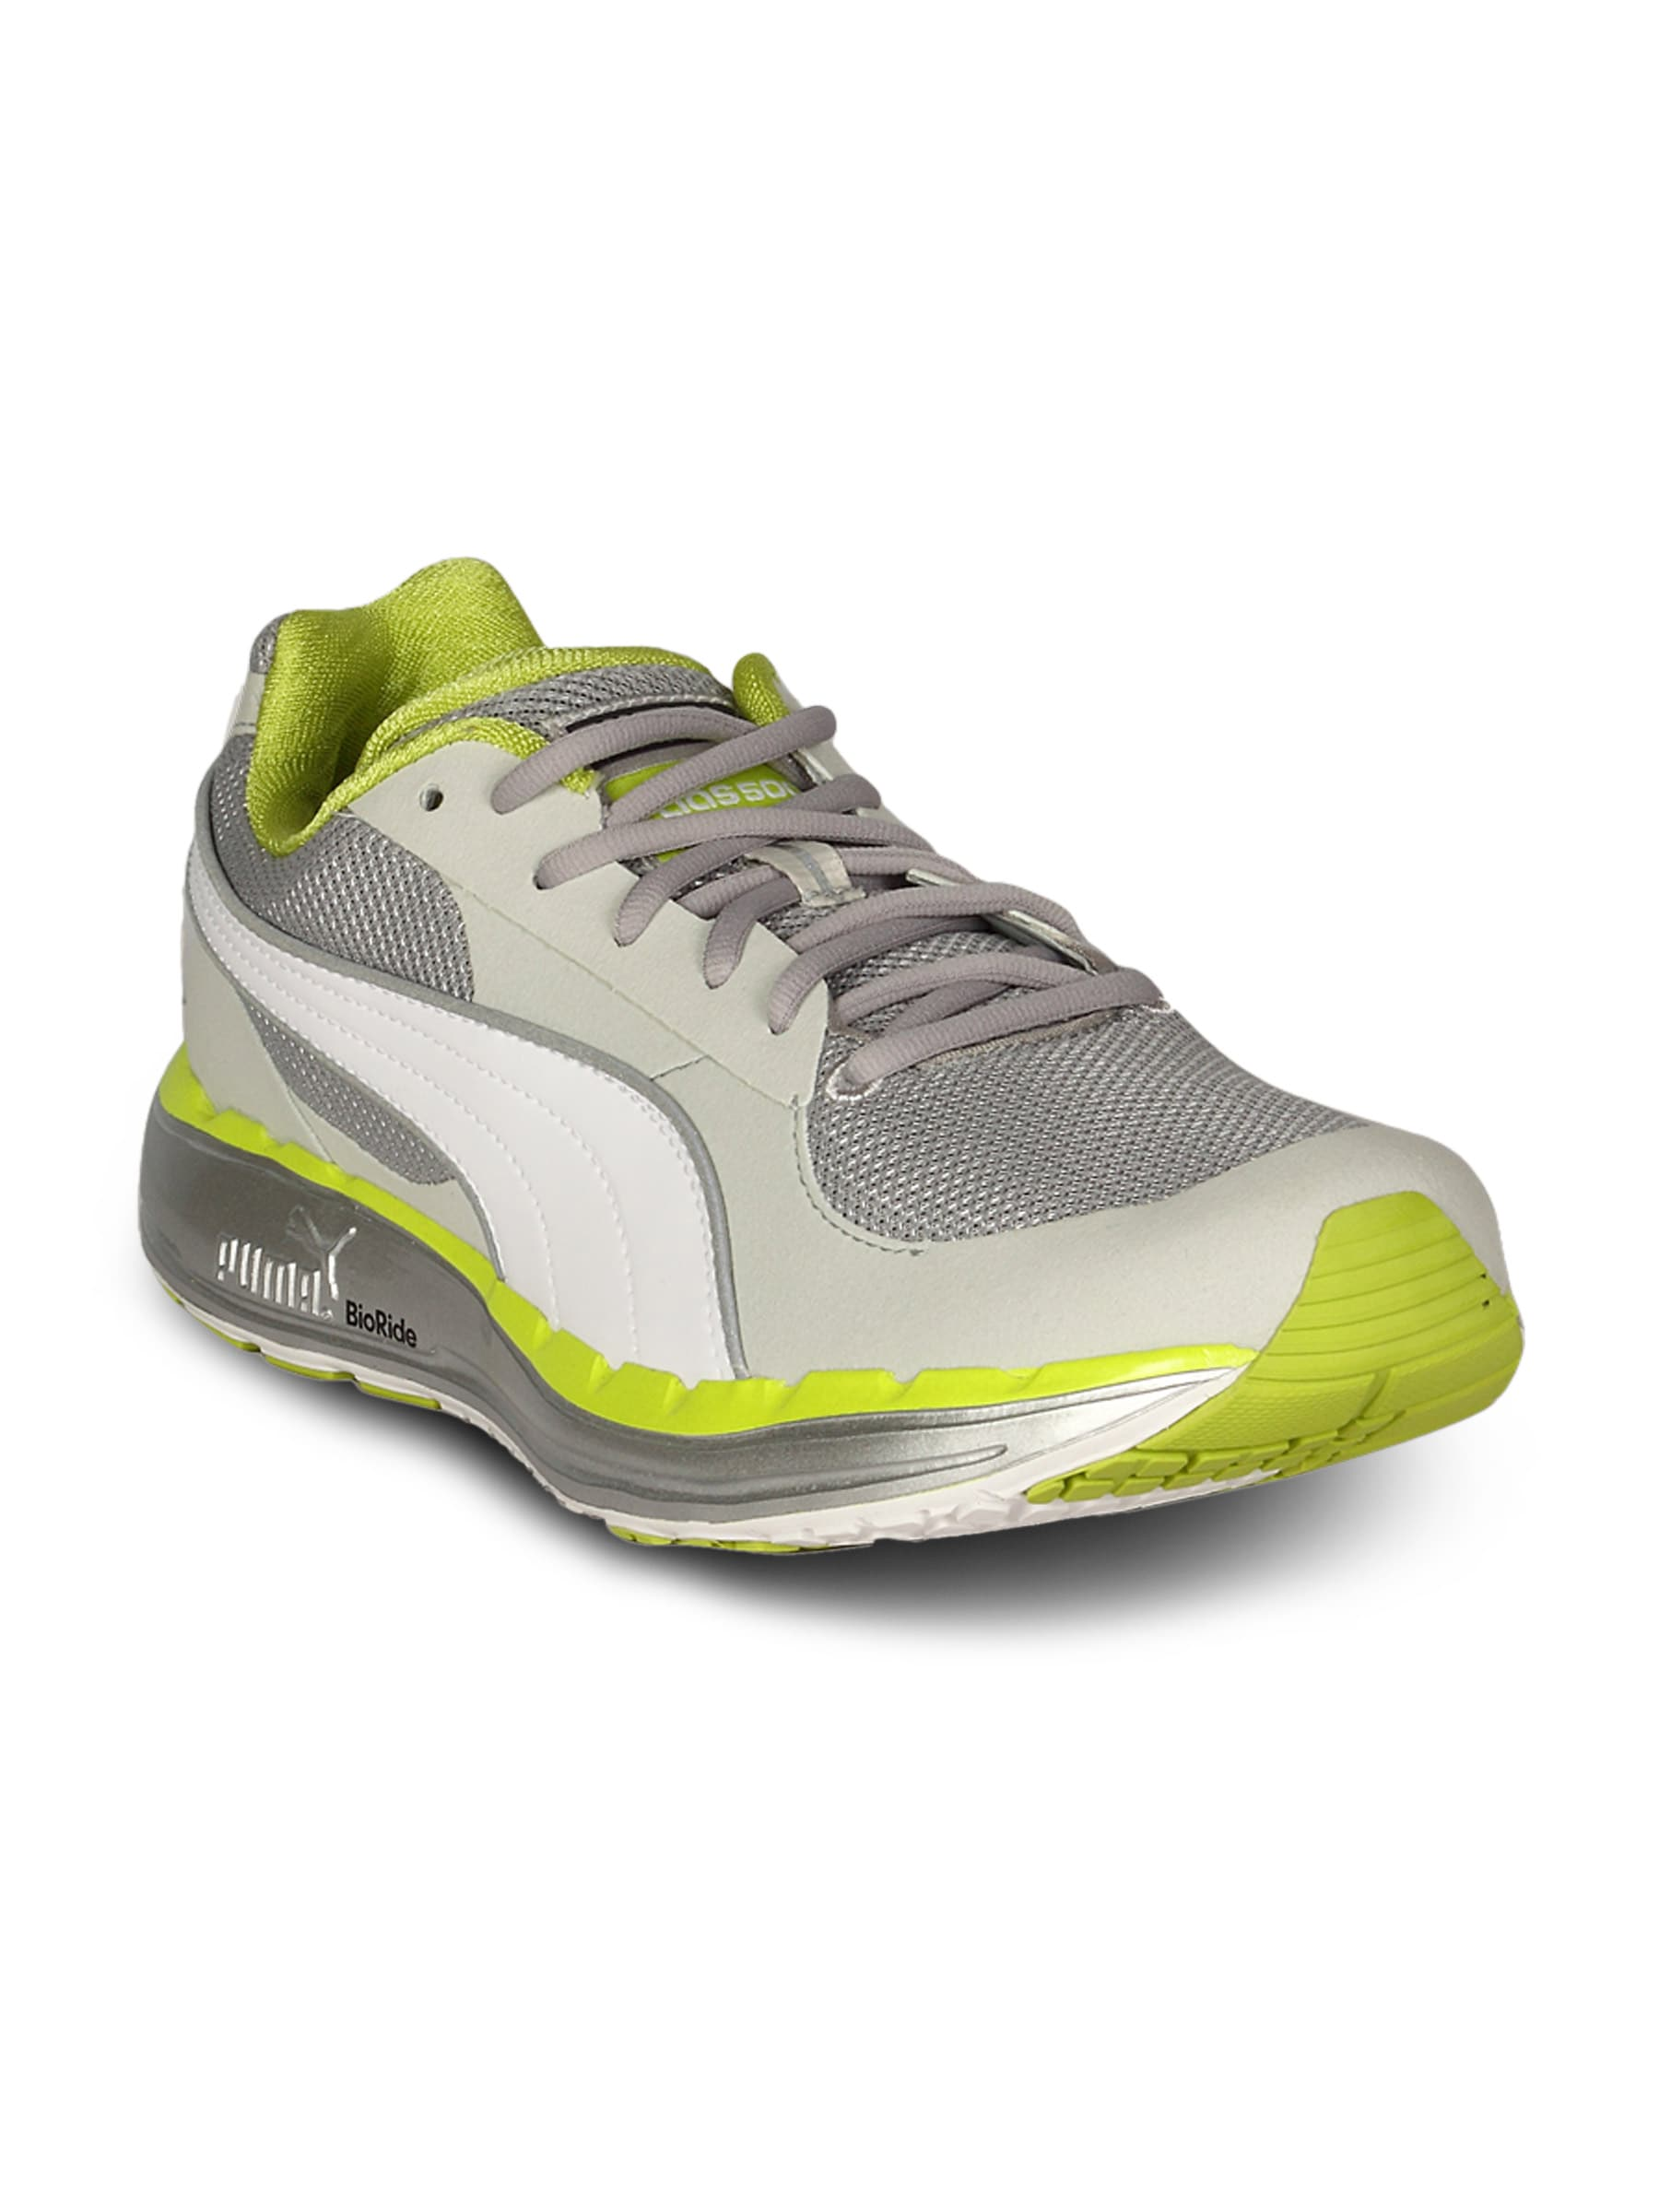

Product Title:  Puma Men's Faas Grey Shoes
Euclidean Distance from input image: 22.556746


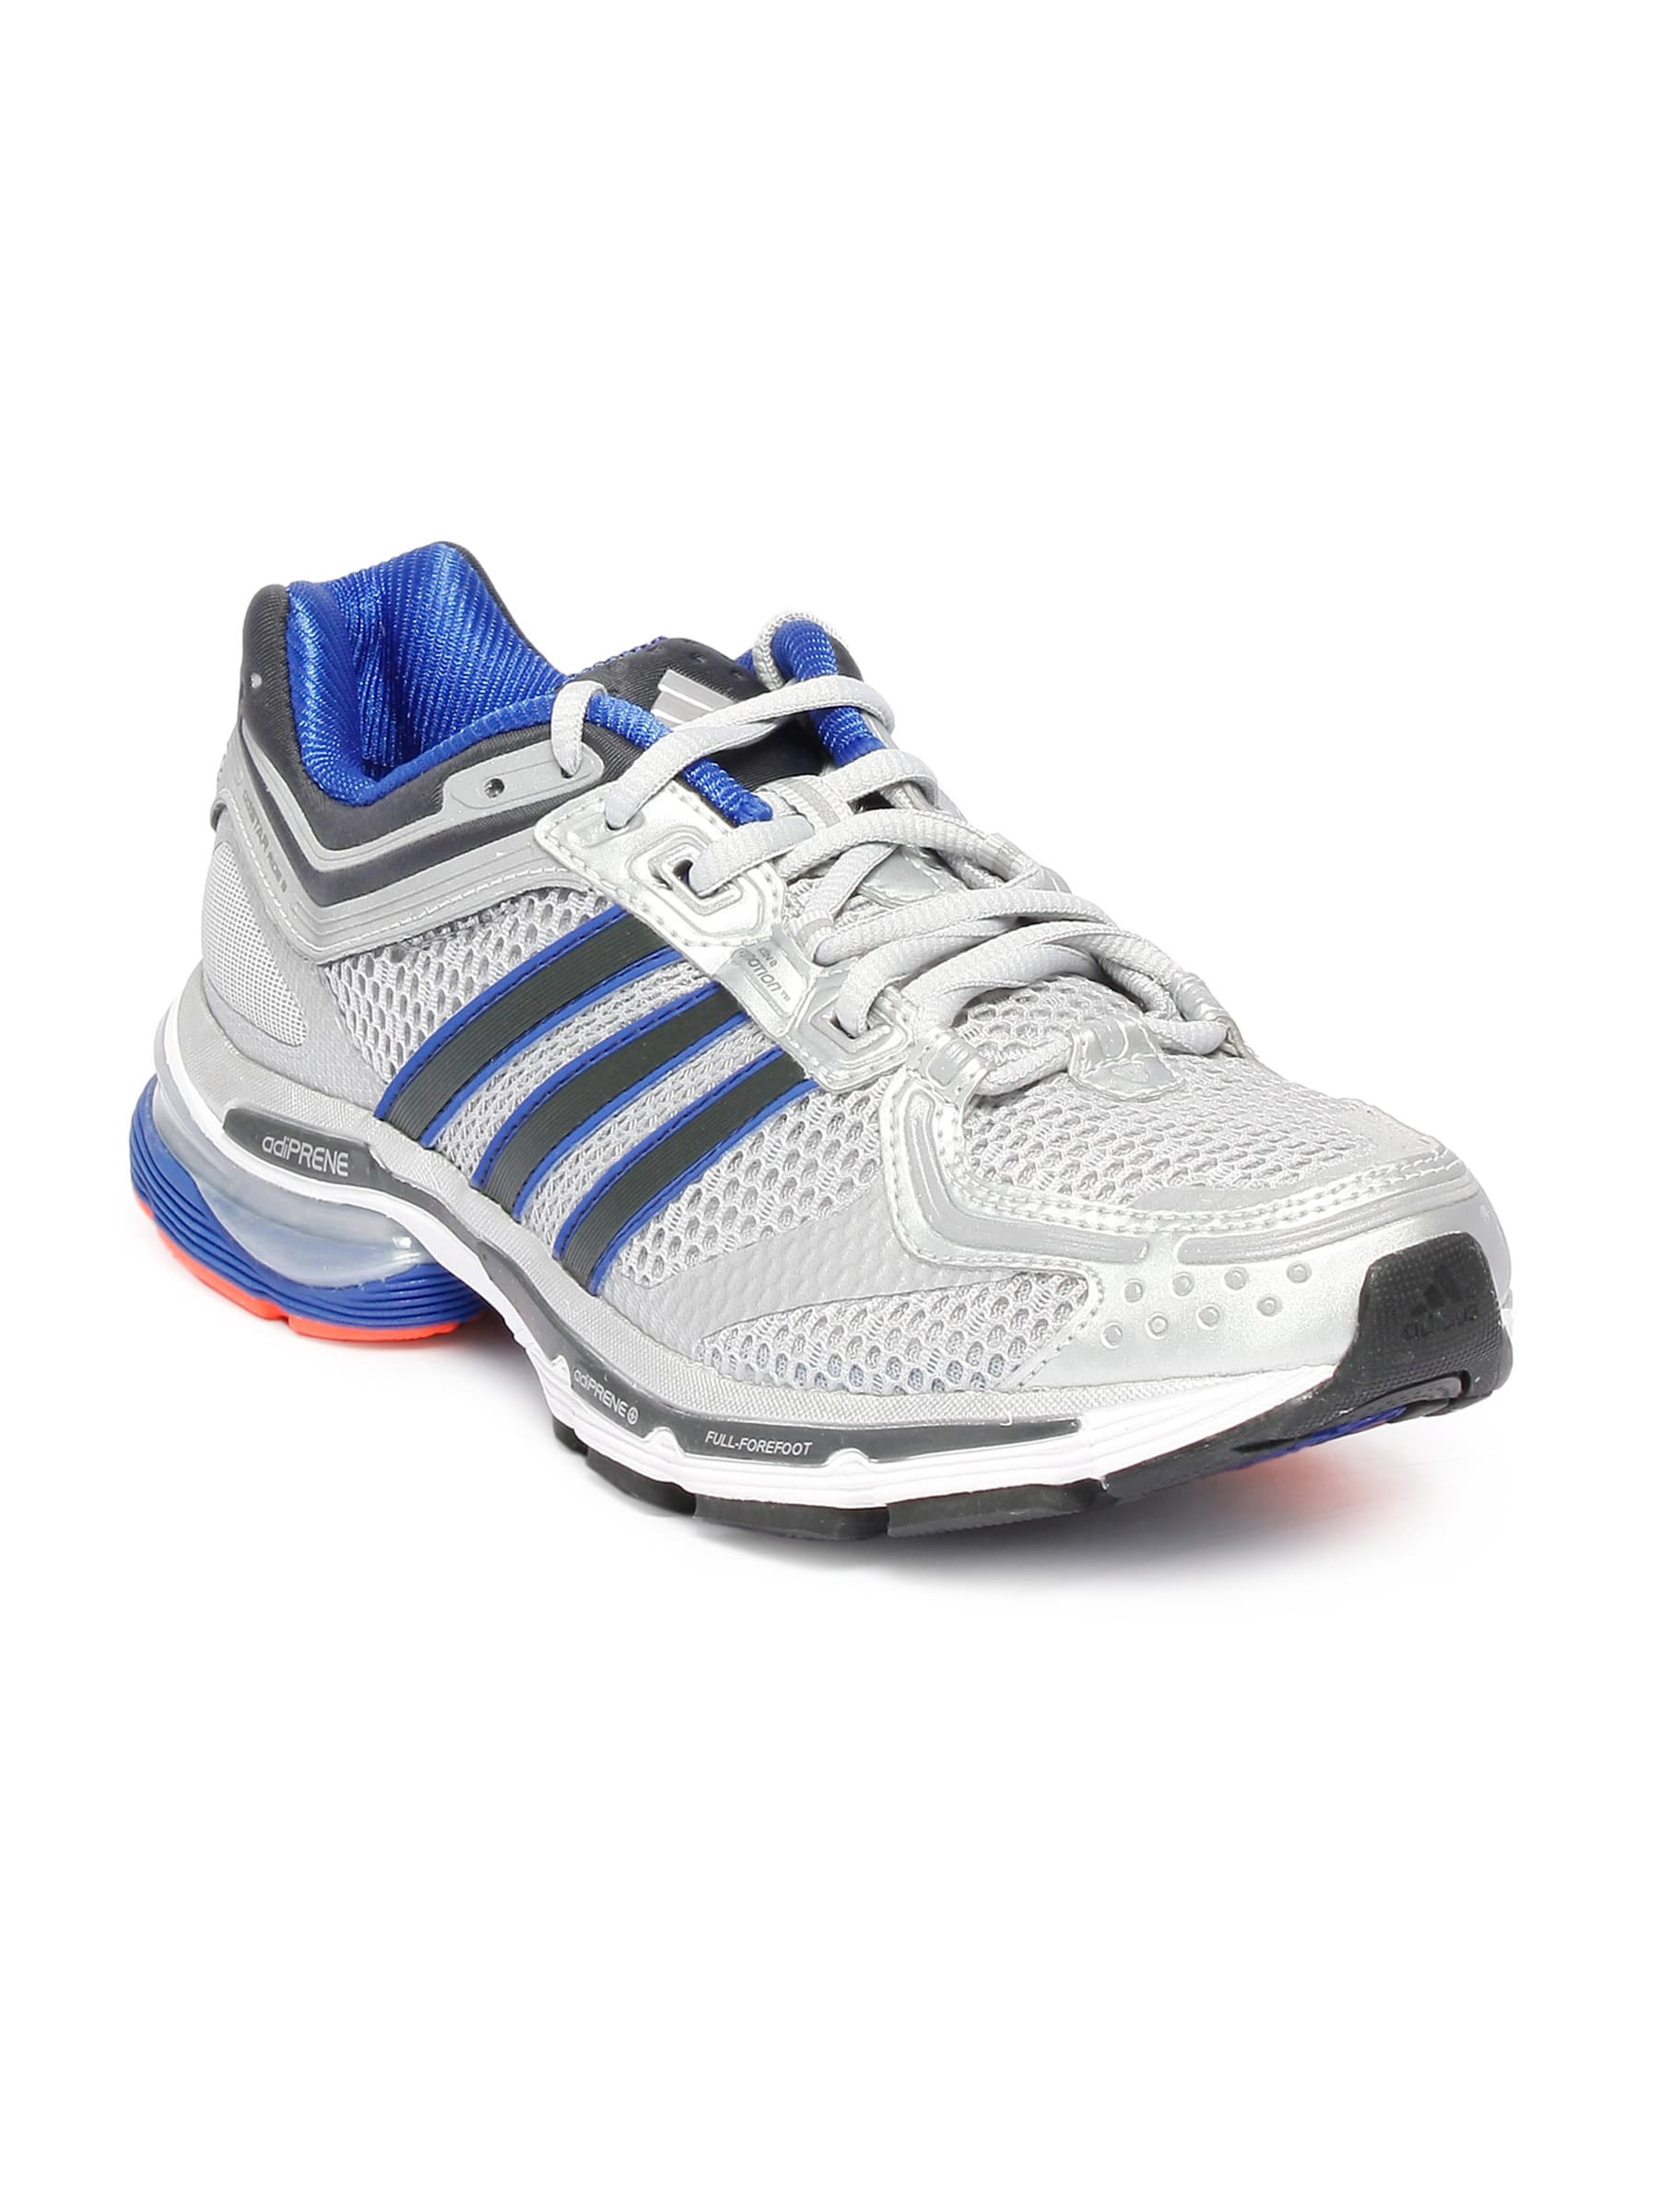

Product Title:  ADIDAS Silver Astar ride 3M Sports Shoe
Euclidean Distance from input image: 22.60063


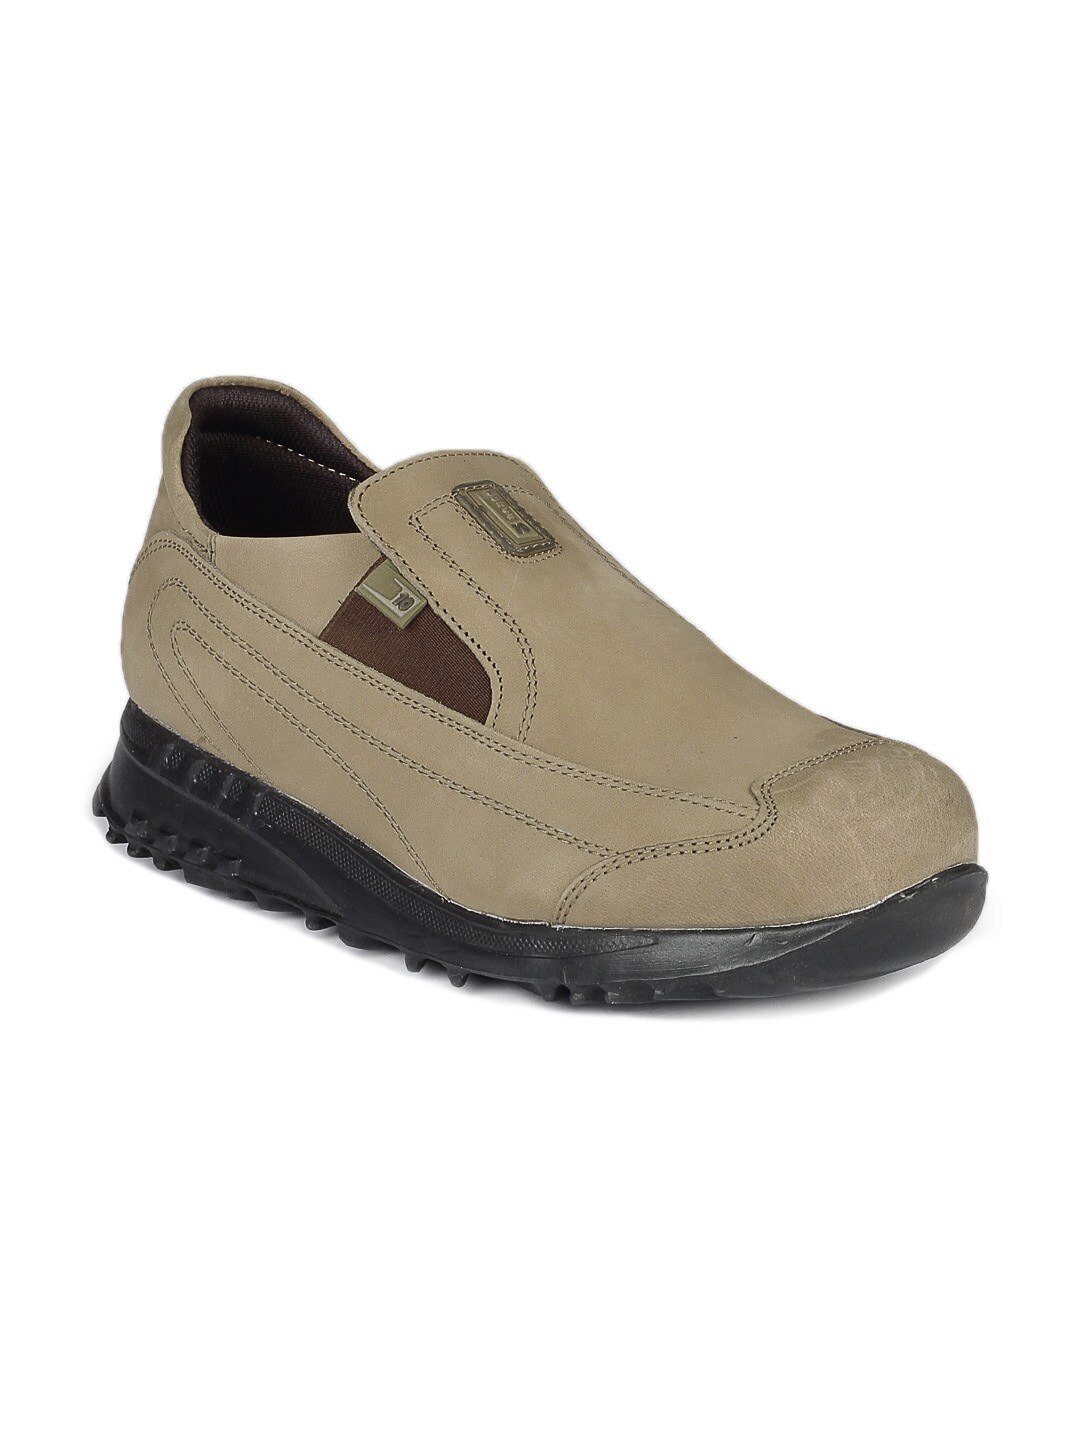

Product Title:  Force 10 Men Brown Shoes
Euclidean Distance from input image: 22.670292


In [10]:
def get_similar_products_cnn(product_id, num_results):
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[0]])]
    #print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['ProductTitle'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])

get_similar_products_cnn('10037', 5)

**NOTE** - The above feature extraction process can be repeated for other genders (Women, Boys and Girls) as well. So let's extract for each one by one.

**For Gender - Women**

In [11]:
img_width, img_height = 224, 224


#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "C:\\Users\\HUSTAR25\\Desktop\\AI\\mobile_project\\data\\Footwear\\Women\\Images\\"

nb_train_samples = 769
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("\\", 26, 50)+1):i.find(".")])
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((769, 100352))
    
    np.save(open('./Women_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Women_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 769 images belonging to 1 classes.


C:\Users\HUSTAR25\AppData\Local\Temp\ipykernel_25672\3135314021.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:01:06.410769


**For Gender - Boys**

In [ ]:
img_width, img_height = 224, 224


#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "C:\\Users\\HUSTAR25\\Desktop\\AI\\mobile_project\\data\\Apparel\\Boys"

nb_train_samples = 759
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((759, 100352))
    
    np.save(open('./Boys_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Boys_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

AttributeError: module 'keras.applications' has no attribute 'ResNet50'

**For Gender - Girls**

In [ ]:
img_width, img_height = 224, 224


#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "/kaggle/input/fashion-images/data/Apparel/Girls/Images"

nb_train_samples = 567
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((567, 100352))
    
    np.save(open('./Girls_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Girls_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

### 5. Deploying the solution

In [ ]:
boys_extracted_features = np.load('/kaggle/working/Boys_ResNet_features.npy')
boys_Productids = np.load('/kaggle/working/Boys_ResNet_feature_product_ids.npy')
girls_extracted_features = np.load('/kaggle/working/Girls_ResNet_features.npy')
girls_Productids = np.load('/kaggle/working/Girls_ResNet_feature_product_ids.npy')
men_extracted_features = np.load('/kaggle/working/Men_ResNet_features.npy')
men_Productids = np.load('/kaggle/working/Men_ResNet_feature_product_ids.npy')
women_extracted_features = np.load('/kaggle/working/Women_ResNet_features.npy')
women_Productids = np.load('/kaggle/working/Women_ResNet_feature_product_ids.npy')
fashion_df["ProductId"] = fashion_df["ProductId"].astype(str)

In [ ]:
def get_similar_products_cnn(product_id, num_results):
    if(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Boys"):
        extracted_features = boys_extracted_features
        Productids = boys_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Girls"):
        extracted_features = girls_extracted_features
        Productids = girls_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Men"):
        extracted_features = men_extracted_features
        Productids = men_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Women"):
        extracted_features = women_extracted_features
        Productids = women_Productids
    Productids = list(Productids)
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product details", "="*20)
    ip_row = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[0]]]
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['ProductTitle'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])

In [ ]:
get_similar_products_cnn('21030', 5)

In [ ]:
get_similar_products_cnn('18181', 5)

In [ ]:
get_similar_products_cnn('37633', 5)

**Tip** - The solution can be deployed using ***streamlit***.

The complete deployment code can be downloaded from [here](https://drive.google.com/file/d/123XGxKvRY7sk2pnTmVOyLp9FH-iFL5oN/view).